In [65]:
import numpy as np
import pandas as pd
import seaborn as sns

import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import model_from_json

from keras.regularizers import l1

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_curve, roc_curve, label_ranking_loss, roc_auc_score
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt

import datetime

import plotly as py
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.graph_objs import Data,Figure

from sklearn.preprocessing import  StandardScaler, MinMaxScaler



In [59]:
# PREPROCESSING

# attach the column names to the dataset
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

# open the csv dataset
df = pd.read_csv("kddcup.data_10_percent.gz",compression='gzip',header=None, names = col_names)

# Remove smurf and neptune attacks
df = df[df.label != 'smurf.']
df = df[df.label != 'neptune.']

# Remove duplicates
df.drop_duplicates(subset=None, keep='first', inplace=True)


#data = df.drop("label", axis=1) #labels serviront pour évaluer la qualité du modèle
target = df["label"]



# One hot encoding
cols_to_dummify = ['protocol_type','service','flag']
data_dummy = pd.get_dummies(df, columns=cols_to_dummify, prefix=cols_to_dummify)
target_dummy = pd.get_dummies(target)
target_categories = target_dummy.columns

# Splitting train/test
X = data_dummy.values
y = target_dummy.values
X_train, X_test = train_test_split(data_dummy, test_size=0.2, random_state = RANDOM_SEED)

#X_train = X_train[X_train['label'] == 'normal.' ] # Only train on normal data (no intrusion)
# X_test = X_test[X_test['label'] == 'normal.']
y_train = X_train['label'] 
ylabel_train= (y_train != 'normal.')
X_train = X_train.drop(['label'], axis=1)
y_test  = X_test['label']
X_test  = X_test.drop(['label'], axis=1)
X_train = X_train.values
X_test  = X_test.values

# Standardize/Normalize dataset?
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print('Training data size   :', X_train.shape)
print('Validation (test) data size :', X_test.shape)
data_dummy.head()

Training data size   : (74500, 109)
Validation (test) data size : (18625, 109)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,181,5450,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0,239,486,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,235,1337,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0,219,1337,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,217,2032,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6301670527984391
[0.46]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.693446088794926
[0.46]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.5631646108039132
[0.47]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.609873708381171
[0.46]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6488567990373045
[0.45]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.623380093520374
[0.46]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6113057696799813
[0.45]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.5860260943787343
[0.44]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6047567825983029
[0.44]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6019948080338845
[0.45]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.5853256389117889
[0.44]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6006548492717625
[0.43]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6147678779257726
[0.44]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

divide by zero encountered in true_divide

/Users/Theo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

invalid value encountered in true_divide



0.6509839402850034
[0.43]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

divide by zero encountered in true_divide

/Users/Theo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

invalid value encountered in true_divide



0.6189341692789969
[0.44]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.641294227188082
[0.43]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.610950313555234
[0.43]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.5987022710257051
[0.44]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6017699115044247
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.57243195785777
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6593020336429827
[0.43]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6242846479223687
[0.44]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.542894442372249
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6101014869011092
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.617980714690868
[0.44]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6822227567957662
[0.43]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.5655412115193644
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.5781914893617021
[0.43]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6055900621118012
[0.44]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6174275958011888
[0.43]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.5972410062212605
[0.44]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.5958371454711802
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.5444281359376764
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.5976926853215514
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.5912240184757506
[0.43]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6192031352057479
[0.43]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6331480545730167
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.5865431496830814
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6136748006764919
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6093623890234059
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6151954085815796
[0.43]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.583428209993675
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6236868295919497
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6191015477538694
[0.43]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.5907417148869016
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.5921222810111699
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6305004597399186
[0.43]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.5979770734996629
[0.43]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6270039187744924
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6363012130922407
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6072631072631073
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6250459052515608
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6105690026612597
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.630546955624355
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

divide by zero encountered in true_divide

/Users/Theo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

invalid value encountered in true_divide



0.5942979520813813
[0.43]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6088495575221239
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6166053357865685
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6340640809443507
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.556651431320664
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

divide by zero encountered in true_divide

/Users/Theo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

invalid value encountered in true_divide



0.6232453677709153
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6169375983219716
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6344361602982292
[0.4]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

divide by zero encountered in true_divide

/Users/Theo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

invalid value encountered in true_divide



0.5987806459981839
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6063707304592554
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.5634500619299628
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6062388136026592
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

divide by zero encountered in true_divide

/Users/Theo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

invalid value encountered in true_divide



0.6492939666238768
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.578289872650091
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6197889182058047
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6421113023522662
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6310419589338095
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6325316141829903
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6013878180416345
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6297406490290629
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

divide by zero encountered in true_divide

/Users/Theo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

invalid value encountered in true_divide



0.6221383647798742
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.591630231105559
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6337603617181612
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6075102880658436
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6402345741968383
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6196350552557183
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.5856729195518067
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6257652020133315
[0.42]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.5962302859340941
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6196762713810126
[0.4]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.5888587626324872
[0.4]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

divide by zero encountered in true_divide

/Users/Theo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

invalid value encountered in true_divide



0.5429929723026043
[0.39]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.5873968492123031
[0.4]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6482159194876488
[0.4]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.5780917143177486
[0.4]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6607724523033969
[0.4]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6329372684297944
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6046025104602512
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6469868045163923
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.635254319197777
[0.4]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

divide by zero encountered in true_divide

/Users/Theo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

invalid value encountered in true_divide



0.6050054406964092
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6340752517223105
[0.41]


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



0.6105775387373543
[0.41]
0.693446088794926
[0.46]
400
800


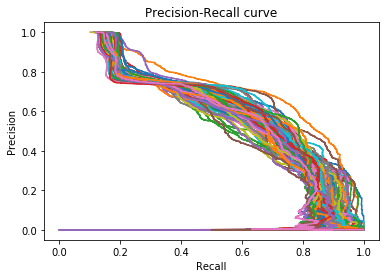

In [60]:
# MODEL BUILDING
imax=0
jmax=0
f1_max=0

for i in range(300,10000,100):
    j=2*i
    #for j in range(100, 10000, 1000):

    rng = np.random.RandomState(i)


    # training the model
    clf = IsolationForest(behaviour='new', max_samples=j, random_state=rng)
    clf.fit(X_train)
    score = -clf.score_samples(X_train)

    # Precision recall curve
    precision, recall, thresholds = precision_recall_curve(ylabel_train, score)

    # ROC curve
    #fpr, tpr, thresholds = roc_curve(ylabel_train, score)

    # F1 score
    f1_score = 2*(precision*recall)/(precision+recall)

    meilleur_f1_score = max(f1_score)
    position = np.where(f1_score==meilleur_f1_score)
    print(meilleur_f1_score)

    # meilleur threshold
    threshold = thresholds[position]
    print(threshold)

    # PLOT precision recall curve
    plt.plot(precision, recall)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')


    #PLOT roc curve
    #plt.plot(fpr, tpr)
    #plt.xlabel('False positive rate')
    #plt.ylabel('True positive rate')
    #plt.title('ROC curve')
    #plt.show()

    # predictions
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    # y_pred_outliers = clf.predict(X_outliers)
    # Meilleurs paramètres
    if meilleur_f1_score>f1_max:
        f1_max=meilleur_f1_score
        imax=i
        jmax=j
        threshold_corres = threshold

print(f1_max)
print(threshold_corres)
print(imax)
print(jmax)
plt.show()
        

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



meilleur f1 score =  0.69
threshold correspondant pour le modèle =  0.46


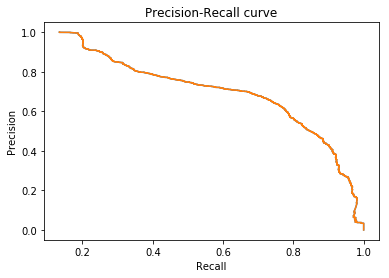

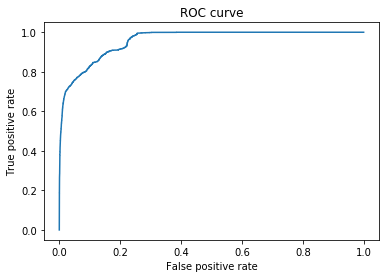

matrice de confusion =
 [[69247  1059]
 [ 1407  2787]]
precision =  0.72
recall =  0.66
aire sous la courbe roc =  0.82


In [89]:
# MODEL BUILDING


rng = np.random.RandomState(400)
        
# training the model
clf = IsolationForest(max_samples=800, random_state=rng)
clf.fit(X_train)
score = -clf.score_samples(X_train)


# Precision recall curve
precision, recall, thresholds = precision_recall_curve(ylabel_train, score)

# PLOT precision recall curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show

# ROC curve
fpr, tpr, thresholds1 = roc_curve(ylabel_train, score)

# F1 score
f1_score = 2*(precision*recall)/(precision+recall)

meilleur_f1_score = max(f1_score)
position = np.where(f1_score==meilleur_f1_score)
print('meilleur f1 score = ', "%.2f" % meilleur_f1_score)

# meilleur threshold
threshold_train = thresholds[position]
print('threshold correspondant pour le modèle = ', "%.2f" % threshold_train)

# PLOT precision recall curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()
#PLOT roc curve
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

#Prediction with calculated best threshold:
Y_predicted = (score>threshold_train)

#Confusion matrix
print('matrice de confusion =\n',confusion_matrix(ylabel_train, Y_predicted,))

#precision= TP/(TP+FP)= proportion des classés positifs qui en sont vraiment
print('precision = ',"%.2f" % precision_score(ylabel_train, Y_predicted,))

#recall= TP/(TP+FN)= proportion 
print('recall = ',"%.2f" % recall_score(ylabel_train, Y_predicted,))

#roc_score
print('aire sous la courbe roc = ',"%.2f" % roc_auc_score(ylabel_train, Y_predicted,))





meilleur f1_score =  0.70
threshold correspondant au meilleur f1_score =  0.46


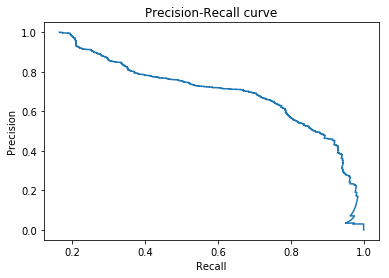

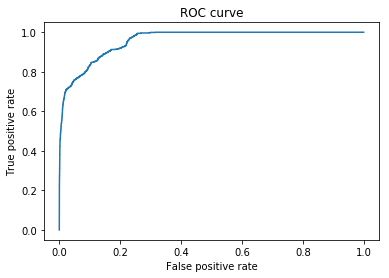

matrice de confusion =
 [[17273   253]
 [  375   724]]
precision =  0.74
recall =  0.66
aire sous la courbe roc =  0.82


In [90]:
#Calcul des scores avec le modèle entrainé
score = -clf.score_samples(X_test)

# Precision recall curve
precision, recall, thresholds = precision_recall_curve((y_test!="normal."), score)

# ROC curve
fpr, tpr, thresholds1 = roc_curve((y_test!="normal."), score)

# F1 score
f1_score = 2*(precision*recall)/(precision+recall)

meilleur_f1_score = max(f1_score)
position = np.where(f1_score==meilleur_f1_score)
np.set_printoptions(precision=2)

print('meilleur f1_score = ',"%.2f" % meilleur_f1_score)

# meilleur threshold
threshold = thresholds[position]
print('threshold correspondant au meilleur f1_score = ',"%.2f" % threshold)

# PLOT precision recall curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

#PLOT roc curve
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

#Prediction with calculated best threshold:
Y_predicted = (score>threshold_train)

#Confusion matrix
print('matrice de confusion =\n',confusion_matrix((y_test!="normal."), Y_predicted,))

#precision= TP/(TP+FP)= proportion des classés positifs qui en sont vraiment
print('precision = ',"%.2f" % precision_score((y_test!="normal."), Y_predicted,))

#recall= TP/(TP+FN)= proportion 
print('recall = ',"%.2f" % recall_score((y_test!="normal."), Y_predicted,))

#roc_score
print('aire sous la courbe roc = ',"%.2f" % roc_auc_score((y_test!="normal."), Y_predicted,))



/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



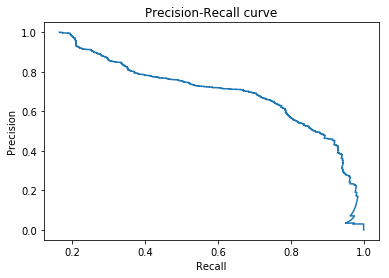

meilleur f1_score =  0.70
threshold correspondant au meilleur f1_score =  0.46


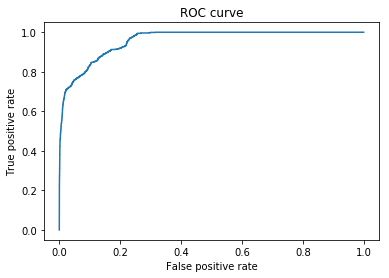

matrice de confusion =
 [[17208   318]
 [  340   759]]
precision =  0.70
recall =  0.69
aire sous la courbe roc =  0.84


In [91]:
# MODEL BUILDING


rng = np.random.RandomState(400)
        
# training the model
clf2 = IsolationForest(max_samples=800, random_state=rng)
clf2.fit(X_test)
score2 = -clf.score_samples(X_test)


# Precision recall curve
precision, recall, thresholds = precision_recall_curve((y_test!="normal."), score)

# PLOT precision recall curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

# ROC curve
fpr, tpr, thresholds1 = roc_curve((y_test!="normal."), score)

# F1 score
f1_score = 2*(precision*recall)/(precision+recall)

meilleur_f1_score = max(f1_score)
position = np.where(f1_score==meilleur_f1_score)

print('meilleur f1_score = ',"%.2f" % meilleur_f1_score)

# meilleur threshold
threshold = thresholds[position]
print('threshold correspondant au meilleur f1_score = ',"%.2f" % threshold)

#PLOT roc curve
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

#Prediction with calculated best threshold:
Y_predicted = (score>threshold)

#Confusion matrix
print('matrice de confusion =\n',confusion_matrix((y_test!="normal."), Y_predicted,))

#precision= TP/(TP+FP)= proportion des classés positifs qui en sont vraiment
print('precision = ',"%.2f" % precision_score((y_test!="normal."), Y_predicted,))

#recall= TP/(TP+FN)= proportion 
print('recall = ',"%.2f" % recall_score((y_test!="normal."), Y_predicted,))

#roc_score
print('aire sous la courbe roc = ',"%.2f" % roc_auc_score((y_test!="normal."), Y_predicted,))

